In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

In [65]:
def compareModelGraph(model1, model2):
    plt.figure(figsize=(15, 10))
    plt.rcParams["font.size"] = "20"
    plt.plot(range(len(model1.yTest)), model1.yTest, label="real")
    plt.plot(range(len(model1.yPred)), model1.yPred, label="model1")
    plt.plot(range(len(model2.yPred)), model2.yPred, label="model2")
    plt.ylabel("y", fontsize=15)
    plt.xlabel("x", fontsize=15)
    plt.legend(loc="lower right", fontsize=15)
    plt.show()
    return

In [72]:
class MLP:
    def __init__(self, xTrain, yTrain, xTest, yTest, batchNorm=None, layerN=3):
        self.xTrain = xTrain
        self.yTrain = yTrain
        self.xTest = xTest
        self.yTest = yTest
        self.trainLen = len(xTrain)
        self.layerN = layerN
        self.batchNorm = batchNorm
        return
    
    def buildModel(self):
        layerN = self.layerN
        batchNorm = self.batchNorm
        model = tf.keras.models.Sequential()
        for i in range(1,(layerN+1)):
            model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
            if not batchNorm and ((isinstance(batchNorm, int) and i == batchNorm) or (isinstance(batchNorm, list) and i in batchNorm)):
                model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss="mse",  metrics=[tf.keras.metrics.RootMeanSquaredError()])
        return (model)

    def train(self, bs=32, ntry=10):
        model = self.buildModel()
        model.fit(self.xTrain, self.yTrain, batch_size=bs, epochs=100, shuffle=True)
        self.bestModel = model
        bestLoss = model.evaluate(self.xTrain[-50:], self.yTrain[-50:])
        
        for i in range(ntry):
            model = self.buildModel()
            model.fit(self.xTrain, self.yTrain, batch_size=bs, epochs=100, shuffle=True)
            if model.evaluate(self.xTrain, self.yTrain) < bestLoss:
                self.bestModel = model
                bestLoss = model.evaluate(self.xTrain[-50:], self.yTrain[-50:])
        return bestLoss

    def predict(self):
        self.yPred = self.bestModel.predict(self.xTest)
        return
    
    def RMSE(self):
        self.rmse = np.sqrt(np.mean(np.square(self.yTest-self.yPred)))
        return
    
    def genGraph(self):
        testLen = len(self.yTest)
        self.predict()

        plt.figure(figsize=(15, 10))
        plt.rcParams["font.size"] = "20"
        plt.plot(range(testLen), self.yTest, label="true")
        plt.plot(range(testLen), self.yPred, label="predict")
        plt.title(f"{} {}")
        plt.ylabel("y", fontsize=15)
        plt.xlabel("x", fontsize=15)
        plt.legend(loc="lower right", fontsize=15)
        plt.show()
        return

In [68]:
class Data:
    def __init__(self):
        self.raw = pd.read_csv("./dataset/dataset.csv", header=[0,1], index_col=0, parse_dates=True)
        self.allFactorNotNA = self.raw.dropna().index
        self.oilPrice = self.raw.iloc[:, self.raw.columns.get_locs(["CL1", "LAST"])].droplevel(1, axis=1)
        self.vol = self.raw.iloc[:, self.raw.columns.get_locs([slice(None), "VOLUME"])].droplevel(1, axis=1)
#         factors = self.raw.drop("CL1", axis=1, level=0)
        self.factors = self.raw.iloc[:, self.raw.columns.get_locs([slice(None), "LAST"])].droplevel(1, axis=1).drop("CL1", axis=1)
        return
    
    def dataMidNoNA(self, data):
        res = data.loc[data.fillna(method="ffill").notna().all(1)].notna().all(1).all()
        print(f"Cleaned data exist NA in middle: {res}")
        return res
    
    def generate_train_test(self, seqLen, covid=True, factor=None, volume=None, split=0.8, trainLen=None, trim=True, norm=False, logRet=False):
        if factor:
            if isinstance(factor, list):
                dfFac = self.factors[factor]
            else:
                dfFac = self.factors
        else:
            dfFac = None
        if volume:
            if isinstance(volume, list):
                dfVol = self.vol[volume]
            elif factor:
                dfVol = self.vol
            else:
                dfVol = self.vol["CL1"]
        else:
            dfVol = None
        df = pd.concat([self.oilPrice, dfFac, dfVol], axis=1)
        if not covid:
            df = df.loc[df.index < "2020-01-01"]
        if trim:
            df = df.loc[self.allFactorNotNA]
        
        if df.isna().any(1).any():
            df.dropna(inplace=True)
            assert self.dataMidNoNA(df)
        
        if logRet:
            df = np.log(df/df.shift()).dropna()
        
        if trainLen is None:
            trainLen = math.ceil(len(df) * split)
        train = df.iloc[:trainLen]
        test = df.iloc[trainLen:]
        print(df.columns)
        if norm:
            l = train.min()
            h = train.max()
            train = (train - l)/(h-l)
            test = (test - l)/(h-l)
        priceTrain = train.iloc[:,0].values
        priceTest = test.iloc[:,0].values
        
        if len(df.columns) > 1:
            xTrain = train.iloc[:,1:].values
            xTest = test.iloc[:,1:].values
        else:
            xTrain = [np.array([])] * len(priceTrain)
            xTest = [np.array([])] * len(priceTest)
        xTrainL, yTrainL, xTestL, yTestL = [], [], [], []
        for i in range(len(priceTrain) - seqLen):
            xTrainL.append(np.hstack([priceTrain[i:(i+seqLen)], xTrain[i+seqLen-1]]))
            yTrainL.append([priceTrain[i+seqLen]])
        for i in range(len(priceTest) - seqLen):
            xTestL.append(np.hstack([priceTest[i:(i+seqLen)], xTest[i+seqLen-1]]))
            yTestL.append([priceTest[i+seqLen]])
        self.trainLen = trainLen
        self.testStartDate = df.index[trainLen]
        return np.array(xTrainL), np.array(yTrainL), np.array(xTestL), np.array(yTestL)

In [69]:
data = Data()

In [70]:
tf.random.set_seed(4012)

In [73]:
xTrain, yTrain, xTest, yTest = data.generate_train_test(5, norm=False, logRet=False)
modelP = MLP(xTrain, yTrain, xTest, yTest)
modelP.train()

Index(['CL1'], dtype='object')
Epoch 1/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5095 - root_mean_squared_error: 52.5025
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5090 - root_mean_squared_error: 52.5025
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5095 - root_mean_squared_error: 52.5025
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 8/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 9/100
41/41 [======

41/41 [==============================] - 0s 1ms/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 70/100
41/41 [==============================] - 0s 994us/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 71/100
41/41 [==============================] - 0s 996us/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 72/100
41/41 [==============================] - 0s 993us/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 73/100
41/41 [==============================] - 0s 998us/step - loss: 2756.5095 - root_mean_squared_error: 52.5025
Epoch 74/100
41/41 [==============================] - 0s 970us/step - loss: 2756.5098 - root_mean_squared_error: 52.5025
Epoch 75/100
41/41 [==============================] - 0s 982us/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 76/100
41/41 [==============================] - 0s 976us/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 77/100
41/41 [===========================

41/41 [==============================] - 0s 2ms/step - loss: 4.4532 - root_mean_squared_error: 2.1103
Epoch 39/100
41/41 [==============================] - 0s 2ms/step - loss: 4.1059 - root_mean_squared_error: 2.0263
Epoch 40/100
41/41 [==============================] - 0s 2ms/step - loss: 4.4228 - root_mean_squared_error: 2.1031
Epoch 41/100
41/41 [==============================] - 0s 2ms/step - loss: 5.7048 - root_mean_squared_error: 2.3885
Epoch 42/100
41/41 [==============================] - 0s 3ms/step - loss: 5.0338 - root_mean_squared_error: 2.2436
Epoch 43/100
41/41 [==============================] - 0s 3ms/step - loss: 4.9828 - root_mean_squared_error: 2.2322
Epoch 44/100
41/41 [==============================] - 0s 2ms/step - loss: 4.9829 - root_mean_squared_error: 2.2322
Epoch 45/100
41/41 [==============================] - 0s 1ms/step - loss: 4.6648 - root_mean_squared_error: 2.1598
Epoch 46/100
41/41 [==============================] - 0s 1ms/step - loss: 5.3515 - root_mean_

41/41 [==============================] - 0s 1ms/step - loss: 4.7934 - root_mean_squared_error: 2.1894
Epoch 8/100
41/41 [==============================] - 0s 1ms/step - loss: 5.2089 - root_mean_squared_error: 2.2823
Epoch 9/100
41/41 [==============================] - 0s 1ms/step - loss: 4.5623 - root_mean_squared_error: 2.1360
Epoch 10/100
41/41 [==============================] - 0s 1ms/step - loss: 4.6585 - root_mean_squared_error: 2.1583
Epoch 11/100
41/41 [==============================] - 0s 1ms/step - loss: 4.5840 - root_mean_squared_error: 2.1410
Epoch 12/100
41/41 [==============================] - 0s 956us/step - loss: 5.2189 - root_mean_squared_error: 2.2845
Epoch 13/100
41/41 [==============================] - 0s 969us/step - loss: 4.4550 - root_mean_squared_error: 2.1107
Epoch 14/100
41/41 [==============================] - 0s 974us/step - loss: 4.7437 - root_mean_squared_error: 2.1780
Epoch 15/100
41/41 [==============================] - 0s 1ms/step - loss: 4.7472 - root_m

41/41 [==============================] - 0s 1ms/step - loss: 4.3294 - root_mean_squared_error: 2.0807
Epoch 78/100
41/41 [==============================] - 0s 1ms/step - loss: 4.1464 - root_mean_squared_error: 2.0363
Epoch 79/100
41/41 [==============================] - 0s 1ms/step - loss: 4.6492 - root_mean_squared_error: 2.1562
Epoch 80/100
41/41 [==============================] - 0s 1ms/step - loss: 4.1923 - root_mean_squared_error: 2.0475
Epoch 81/100
41/41 [==============================] - 0s 1ms/step - loss: 4.2387 - root_mean_squared_error: 2.0588
Epoch 82/100
41/41 [==============================] - 0s 938us/step - loss: 4.9400 - root_mean_squared_error: 2.2226
Epoch 83/100
41/41 [==============================] - 0s 962us/step - loss: 4.4317 - root_mean_squared_error: 2.1052
Epoch 84/100
41/41 [==============================] - 0s 1ms/step - loss: 4.6322 - root_mean_squared_error: 2.1523
Epoch 85/100
41/41 [==============================] - 0s 1ms/step - loss: 4.8335 - root_m

41/41 [==============================] - 0s 1ms/step - loss: 4.4401 - root_mean_squared_error: 2.1072
Epoch 48/100
41/41 [==============================] - 0s 1ms/step - loss: 4.7364 - root_mean_squared_error: 2.1763
Epoch 49/100
41/41 [==============================] - 0s 1ms/step - loss: 5.2663 - root_mean_squared_error: 2.2948
Epoch 50/100
41/41 [==============================] - 0s 1ms/step - loss: 4.7932 - root_mean_squared_error: 2.1893
Epoch 51/100
41/41 [==============================] - 0s 936us/step - loss: 5.3950 - root_mean_squared_error: 2.3227
Epoch 52/100
41/41 [==============================] - 0s 953us/step - loss: 5.4651 - root_mean_squared_error: 2.3378
Epoch 53/100
41/41 [==============================] - 0s 947us/step - loss: 4.1159 - root_mean_squared_error: 2.0288
Epoch 54/100
41/41 [==============================] - 0s 936us/step - loss: 5.5464 - root_mean_squared_error: 2.3551
Epoch 55/100
41/41 [==============================] - 0s 1ms/step - loss: 4.3058 - ro

41/41 [==============================] - 0s 1ms/step - loss: 4.5710 - root_mean_squared_error: 2.1380
Epoch 18/100
41/41 [==============================] - 0s 1ms/step - loss: 4.2290 - root_mean_squared_error: 2.0565
Epoch 19/100
41/41 [==============================] - 0s 968us/step - loss: 4.3670 - root_mean_squared_error: 2.0897
Epoch 20/100
41/41 [==============================] - 0s 983us/step - loss: 4.6820 - root_mean_squared_error: 2.1638
Epoch 21/100
41/41 [==============================] - 0s 978us/step - loss: 4.8468 - root_mean_squared_error: 2.2015
Epoch 22/100
41/41 [==============================] - 0s 962us/step - loss: 4.0241 - root_mean_squared_error: 2.0060
Epoch 23/100
41/41 [==============================] - 0s 980us/step - loss: 4.3688 - root_mean_squared_error: 2.0902
Epoch 24/100
41/41 [==============================] - 0s 937us/step - loss: 5.1056 - root_mean_squared_error: 2.2596
Epoch 25/100
41/41 [==============================] - 0s 924us/step - loss: 4.329

41/41 [==============================] - 0s 1ms/step - loss: 4.5484 - root_mean_squared_error: 2.1327
Epoch 88/100
41/41 [==============================] - 0s 976us/step - loss: 4.2053 - root_mean_squared_error: 2.0507
Epoch 89/100
41/41 [==============================] - 0s 922us/step - loss: 4.0912 - root_mean_squared_error: 2.0227
Epoch 90/100
41/41 [==============================] - 0s 984us/step - loss: 4.8295 - root_mean_squared_error: 2.1976
Epoch 91/100
41/41 [==============================] - 0s 1ms/step - loss: 4.8246 - root_mean_squared_error: 2.1965
Epoch 92/100
41/41 [==============================] - 0s 1ms/step - loss: 4.2811 - root_mean_squared_error: 2.0691
Epoch 93/100
41/41 [==============================] - 0s 1ms/step - loss: 4.3228 - root_mean_squared_error: 2.0791
Epoch 94/100
41/41 [==============================] - 0s 1ms/step - loss: 4.1828 - root_mean_squared_error: 2.0452
Epoch 95/100
41/41 [==============================] - 0s 1ms/step - loss: 5.0867 - root

41/41 [==============================] - 0s 988us/step - loss: 4.1382 - root_mean_squared_error: 2.0343
Epoch 58/100
41/41 [==============================] - 0s 959us/step - loss: 4.0572 - root_mean_squared_error: 2.0142
Epoch 59/100
41/41 [==============================] - 0s 935us/step - loss: 4.2782 - root_mean_squared_error: 2.0684
Epoch 60/100
41/41 [==============================] - 0s 1ms/step - loss: 4.3014 - root_mean_squared_error: 2.0740
Epoch 61/100
41/41 [==============================] - 0s 934us/step - loss: 4.4025 - root_mean_squared_error: 2.0982
Epoch 62/100
41/41 [==============================] - 0s 963us/step - loss: 4.7347 - root_mean_squared_error: 2.1759
Epoch 63/100
41/41 [==============================] - 0s 916us/step - loss: 4.6872 - root_mean_squared_error: 2.1650
Epoch 64/100
41/41 [==============================] - 0s 953us/step - loss: 4.4400 - root_mean_squared_error: 2.1071
Epoch 65/100
41/41 [==============================] - 0s 1ms/step - loss: 5.605

41/41 [==============================] - 0s 1ms/step - loss: 5.0175 - root_mean_squared_error: 2.2400
Epoch 28/100
41/41 [==============================] - 0s 1ms/step - loss: 4.4784 - root_mean_squared_error: 2.1162
Epoch 29/100
41/41 [==============================] - 0s 1ms/step - loss: 5.3896 - root_mean_squared_error: 2.3215
Epoch 30/100
41/41 [==============================] - 0s 976us/step - loss: 4.3048 - root_mean_squared_error: 2.0748
Epoch 31/100
41/41 [==============================] - 0s 962us/step - loss: 4.2232 - root_mean_squared_error: 2.0550
Epoch 32/100
41/41 [==============================] - 0s 938us/step - loss: 3.9415 - root_mean_squared_error: 1.9853
Epoch 33/100
41/41 [==============================] - 0s 926us/step - loss: 4.6334 - root_mean_squared_error: 2.1525
Epoch 34/100
41/41 [==============================] - 0s 989us/step - loss: 4.3270 - root_mean_squared_error: 2.0801
Epoch 35/100
41/41 [==============================] - 0s 924us/step - loss: 4.8849 

41/41 [==============================] - 0s 994us/step - loss: 3.9743 - root_mean_squared_error: 1.9936
Epoch 99/100
41/41 [==============================] - 0s 1ms/step - loss: 6.6845 - root_mean_squared_error: 2.5854
Epoch 100/100
41/41 [==============================] - 0s 834us/step - loss: 3.8659 - root_mean_squared_error: 1.9662
Epoch 1/100
41/41 [==============================] - 0s 1ms/step - loss: 107.2129 - root_mean_squared_error: 10.3544
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 6.3642 - root_mean_squared_error: 2.5227
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 5.4705 - root_mean_squared_error: 2.3389
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 5.3541 - root_mean_squared_error: 2.3139
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 5.5093 - root_mean_squared_error: 2.3472
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 4.7490 - root_mea

41/41 [==============================] - 0s 1ms/step - loss: 4.1477 - root_mean_squared_error: 2.0366
Epoch 69/100
41/41 [==============================] - 0s 1ms/step - loss: 4.1414 - root_mean_squared_error: 2.0351
Epoch 70/100
41/41 [==============================] - 0s 923us/step - loss: 4.7185 - root_mean_squared_error: 2.1722
Epoch 71/100
41/41 [==============================] - 0s 1ms/step - loss: 4.5010 - root_mean_squared_error: 2.1216
Epoch 72/100
41/41 [==============================] - 0s 1ms/step - loss: 5.1603 - root_mean_squared_error: 2.2716
Epoch 73/100
41/41 [==============================] - 0s 1ms/step - loss: 4.7712 - root_mean_squared_error: 2.1843
Epoch 74/100
41/41 [==============================] - 0s 1ms/step - loss: 4.0886 - root_mean_squared_error: 2.0220
Epoch 75/100
41/41 [==============================] - 0s 1ms/step - loss: 5.1929 - root_mean_squared_error: 2.2788
Epoch 76/100
41/41 [==============================] - 0s 1ms/step - loss: 4.8344 - root_mea

41/41 [==============================] - 0s 984us/step - loss: 4.2244 - root_mean_squared_error: 2.0553
Epoch 39/100
41/41 [==============================] - 0s 986us/step - loss: 4.2972 - root_mean_squared_error: 2.0730
Epoch 40/100
41/41 [==============================] - 0s 968us/step - loss: 4.4884 - root_mean_squared_error: 2.1186
Epoch 41/100
41/41 [==============================] - 0s 954us/step - loss: 5.2155 - root_mean_squared_error: 2.2838
Epoch 42/100
41/41 [==============================] - 0s 975us/step - loss: 5.0504 - root_mean_squared_error: 2.2473
Epoch 43/100
41/41 [==============================] - 0s 958us/step - loss: 4.9002 - root_mean_squared_error: 2.2136
Epoch 44/100
41/41 [==============================] - 0s 907us/step - loss: 5.0893 - root_mean_squared_error: 2.2559
Epoch 45/100
41/41 [==============================] - 0s 955us/step - loss: 4.3200 - root_mean_squared_error: 2.0785
Epoch 46/100
41/41 [==============================] - 0s 947us/step - loss: 5

41/41 [==============================] - 0s 1ms/step - loss: 4.6241 - root_mean_squared_error: 2.1504
Epoch 8/100
41/41 [==============================] - 0s 1ms/step - loss: 4.6391 - root_mean_squared_error: 2.1539
Epoch 9/100
41/41 [==============================] - 0s 1ms/step - loss: 4.2932 - root_mean_squared_error: 2.0720
Epoch 10/100
41/41 [==============================] - 0s 993us/step - loss: 4.0335 - root_mean_squared_error: 2.0083
Epoch 11/100
41/41 [==============================] - 0s 920us/step - loss: 4.3458 - root_mean_squared_error: 2.0847
Epoch 12/100
41/41 [==============================] - 0s 907us/step - loss: 4.9530 - root_mean_squared_error: 2.2255
Epoch 13/100
41/41 [==============================] - 0s 940us/step - loss: 4.5939 - root_mean_squared_error: 2.1433
Epoch 14/100
41/41 [==============================] - 0s 947us/step - loss: 4.7197 - root_mean_squared_error: 2.1725
Epoch 15/100
41/41 [==============================] - 0s 950us/step - loss: 4.6685 - 

41/41 [==============================] - 0s 1ms/step - loss: 5.3345 - root_mean_squared_error: 2.3097
Epoch 78/100
41/41 [==============================] - 0s 1ms/step - loss: 5.3739 - root_mean_squared_error: 2.3182
Epoch 79/100
41/41 [==============================] - 0s 1ms/step - loss: 4.2272 - root_mean_squared_error: 2.0560
Epoch 80/100
41/41 [==============================] - 0s 1ms/step - loss: 4.4103 - root_mean_squared_error: 2.1001
Epoch 81/100
41/41 [==============================] - 0s 1ms/step - loss: 4.5191 - root_mean_squared_error: 2.1258
Epoch 82/100
41/41 [==============================] - 0s 1ms/step - loss: 4.5400 - root_mean_squared_error: 2.1307
Epoch 83/100
41/41 [==============================] - 0s 1ms/step - loss: 4.3672 - root_mean_squared_error: 2.0898
Epoch 84/100
41/41 [==============================] - 0s 1ms/step - loss: 4.3625 - root_mean_squared_error: 2.0887
Epoch 85/100
41/41 [==============================] - 0s 976us/step - loss: 4.0897 - root_mea

41/41 [==============================] - 0s 1ms/step - loss: 5.3837 - root_mean_squared_error: 2.3203
Epoch 47/100
41/41 [==============================] - 0s 1ms/step - loss: 4.5381 - root_mean_squared_error: 2.1303
Epoch 48/100
41/41 [==============================] - 0s 1ms/step - loss: 4.5833 - root_mean_squared_error: 2.1409
Epoch 49/100
41/41 [==============================] - 0s 983us/step - loss: 5.2751 - root_mean_squared_error: 2.2968
Epoch 50/100
41/41 [==============================] - 0s 1ms/step - loss: 5.3678 - root_mean_squared_error: 2.3169
Epoch 51/100
41/41 [==============================] - 0s 1ms/step - loss: 4.6927 - root_mean_squared_error: 2.1663
Epoch 52/100
41/41 [==============================] - 0s 969us/step - loss: 4.5872 - root_mean_squared_error: 2.1418
Epoch 53/100
41/41 [==============================] - 0s 1ms/step - loss: 4.4019 - root_mean_squared_error: 2.0981
Epoch 54/100
41/41 [==============================] - 0s 939us/step - loss: 4.9571 - root

[1.04741370677948, 1.0234323740005493]

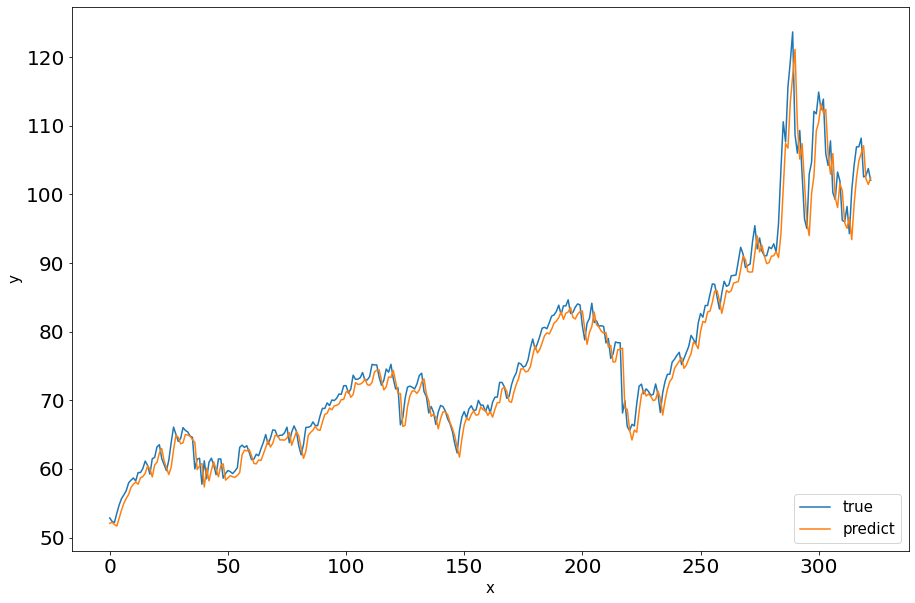

In [74]:
modelP.genGraph()

In [77]:
modelP_B1 = MLP(xTrain, yTrain, xTest, yTest, batchNorm=1)
modelP_B1.train()

Epoch 1/100
41/41 [==============================] - 0s 1ms/step - loss: 73.1522 - root_mean_squared_error: 8.5529
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 7.5823 - root_mean_squared_error: 2.7536
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 7.4231 - root_mean_squared_error: 2.7245
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 5.8861 - root_mean_squared_error: 2.4261
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 6.1712 - root_mean_squared_error: 2.4842
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 5.4580 - root_mean_squared_error: 2.3362
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 5.7032 - root_mean_squared_error: 2.3881
Epoch 8/100
41/41 [==============================] - 0s 1ms/step - loss: 6.1339 - root_mean_squared_error: 2.4767
Epoch 9/100
41/41 [==============================] - 0s 1ms/step - loss: 4.8352 - root_

41/41 [==============================] - 0s 1ms/step - loss: 5.0387 - root_mean_squared_error: 2.2447
Epoch 73/100
41/41 [==============================] - 0s 1ms/step - loss: 6.5520 - root_mean_squared_error: 2.5597
Epoch 74/100
41/41 [==============================] - 0s 1ms/step - loss: 4.3913 - root_mean_squared_error: 2.0956
Epoch 75/100
41/41 [==============================] - 0s 960us/step - loss: 4.9880 - root_mean_squared_error: 2.2334
Epoch 76/100
41/41 [==============================] - 0s 976us/step - loss: 4.0306 - root_mean_squared_error: 2.0076
Epoch 77/100
41/41 [==============================] - 0s 949us/step - loss: 5.1123 - root_mean_squared_error: 2.2610
Epoch 78/100
41/41 [==============================] - 0s 980us/step - loss: 4.5586 - root_mean_squared_error: 2.1351
Epoch 79/100
41/41 [==============================] - 0s 953us/step - loss: 4.2378 - root_mean_squared_error: 2.0586
Epoch 80/100
41/41 [==============================] - 0s 982us/step - loss: 4.2849 

41/41 [==============================] - 0s 1ms/step - loss: 5.1311 - root_mean_squared_error: 2.2652
Epoch 43/100
41/41 [==============================] - 0s 1ms/step - loss: 4.9754 - root_mean_squared_error: 2.2306
Epoch 44/100
41/41 [==============================] - 0s 1ms/step - loss: 4.9939 - root_mean_squared_error: 2.2347
Epoch 45/100
41/41 [==============================] - 0s 988us/step - loss: 4.6983 - root_mean_squared_error: 2.1676
Epoch 46/100
41/41 [==============================] - 0s 967us/step - loss: 5.5275 - root_mean_squared_error: 2.3511
Epoch 47/100
41/41 [==============================] - 0s 944us/step - loss: 4.4754 - root_mean_squared_error: 2.1155
Epoch 48/100
41/41 [==============================] - 0s 917us/step - loss: 4.7716 - root_mean_squared_error: 2.1844
Epoch 49/100
41/41 [==============================] - 0s 1ms/step - loss: 5.3489 - root_mean_squared_error: 2.3128
Epoch 50/100
41/41 [==============================] - 0s 1ms/step - loss: 5.0154 - ro

41/41 [==============================] - 0s 983us/step - loss: 2756.5090 - root_mean_squared_error: 52.5025
Epoch 12/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 13/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 14/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5095 - root_mean_squared_error: 52.5025
Epoch 15/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5090 - root_mean_squared_error: 52.5025
Epoch 16/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5098 - root_mean_squared_error: 52.5025
Epoch 17/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 18/100
41/41 [==============================] - 0s 1ms/step - loss: 2756.5095 - root_mean_squared_error: 52.5025
Epoch 19/100
41/41 [==============================] - 0s 1m

41/41 [==============================] - 0s 957us/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 80/100
41/41 [==============================] - 0s 967us/step - loss: 2756.5098 - root_mean_squared_error: 52.5025
Epoch 81/100
41/41 [==============================] - 0s 914us/step - loss: 2756.5090 - root_mean_squared_error: 52.5025
Epoch 82/100
41/41 [==============================] - 0s 939us/step - loss: 2756.5100 - root_mean_squared_error: 52.5025
Epoch 83/100
41/41 [==============================] - 0s 944us/step - loss: 2756.5095 - root_mean_squared_error: 52.5025
Epoch 84/100
41/41 [==============================] - 0s 942us/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 85/100
41/41 [==============================] - 0s 924us/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 86/100
41/41 [==============================] - 0s 931us/step - loss: 2756.5093 - root_mean_squared_error: 52.5025
Epoch 87/100
41/41 [=========================

41/41 [==============================] - 0s 937us/step - loss: 4.4959 - root_mean_squared_error: 2.1204
Epoch 48/100
41/41 [==============================] - 0s 941us/step - loss: 4.7992 - root_mean_squared_error: 2.1907
Epoch 49/100
41/41 [==============================] - 0s 943us/step - loss: 5.3948 - root_mean_squared_error: 2.3227
Epoch 50/100
41/41 [==============================] - 0s 940us/step - loss: 4.9836 - root_mean_squared_error: 2.2324
Epoch 51/100
41/41 [==============================] - 0s 942us/step - loss: 5.8146 - root_mean_squared_error: 2.4113
Epoch 52/100
41/41 [==============================] - 0s 950us/step - loss: 5.7485 - root_mean_squared_error: 2.3976
Epoch 53/100
41/41 [==============================] - 0s 956us/step - loss: 4.6500 - root_mean_squared_error: 2.1564
Epoch 54/100
41/41 [==============================] - 0s 956us/step - loss: 5.1399 - root_mean_squared_error: 2.2671
Epoch 55/100
41/41 [==============================] - 0s 967us/step - loss: 4

41/41 [==============================] - 0s 987us/step - loss: 4.1609 - root_mean_squared_error: 2.0398
Epoch 17/100
41/41 [==============================] - 0s 1ms/step - loss: 4.2856 - root_mean_squared_error: 2.0702
Epoch 18/100
41/41 [==============================] - 0s 927us/step - loss: 4.0606 - root_mean_squared_error: 2.0151
Epoch 19/100
41/41 [==============================] - 0s 912us/step - loss: 4.0140 - root_mean_squared_error: 2.0035
Epoch 20/100
41/41 [==============================] - 0s 932us/step - loss: 4.5065 - root_mean_squared_error: 2.1228
Epoch 21/100
41/41 [==============================] - 0s 968us/step - loss: 4.7245 - root_mean_squared_error: 2.1736
Epoch 22/100
41/41 [==============================] - 0s 942us/step - loss: 4.0245 - root_mean_squared_error: 2.0061
Epoch 23/100
41/41 [==============================] - 0s 917us/step - loss: 4.4451 - root_mean_squared_error: 2.1083
Epoch 24/100
41/41 [==============================] - 0s 912us/step - loss: 4.7

41/41 [==============================] - 0s 1ms/step - loss: 5.4735 - root_mean_squared_error: 2.3396
Epoch 87/100
41/41 [==============================] - 0s 924us/step - loss: 4.4184 - root_mean_squared_error: 2.1020
Epoch 88/100
41/41 [==============================] - 0s 951us/step - loss: 4.1704 - root_mean_squared_error: 2.0422
Epoch 89/100
41/41 [==============================] - 0s 900us/step - loss: 4.0813 - root_mean_squared_error: 2.0202
Epoch 90/100
41/41 [==============================] - 0s 934us/step - loss: 4.2027 - root_mean_squared_error: 2.0500
Epoch 91/100
41/41 [==============================] - 0s 949us/step - loss: 4.6536 - root_mean_squared_error: 2.1572
Epoch 92/100
41/41 [==============================] - 0s 928us/step - loss: 4.2251 - root_mean_squared_error: 2.0555
Epoch 93/100
41/41 [==============================] - 0s 918us/step - loss: 4.5213 - root_mean_squared_error: 2.1263
Epoch 94/100
41/41 [==============================] - 0s 970us/step - loss: 4.1

41/41 [==============================] - 0s 943us/step - loss: 4.2002 - root_mean_squared_error: 2.0494
Epoch 56/100
41/41 [==============================] - 0s 975us/step - loss: 4.1568 - root_mean_squared_error: 2.0388
Epoch 57/100
41/41 [==============================] - 0s 946us/step - loss: 4.2504 - root_mean_squared_error: 2.0616
Epoch 58/100
41/41 [==============================] - 0s 927us/step - loss: 3.9655 - root_mean_squared_error: 1.9914
Epoch 59/100
41/41 [==============================] - 0s 915us/step - loss: 4.1443 - root_mean_squared_error: 2.0358
Epoch 60/100
41/41 [==============================] - 0s 928us/step - loss: 4.4920 - root_mean_squared_error: 2.1194
Epoch 61/100
41/41 [==============================] - 0s 951us/step - loss: 4.2112 - root_mean_squared_error: 2.0521
Epoch 62/100
41/41 [==============================] - 0s 936us/step - loss: 4.5268 - root_mean_squared_error: 2.1276
Epoch 63/100
41/41 [==============================] - 0s 920us/step - loss: 4

41/41 [==============================] - 0s 929us/step - loss: 4.7363 - root_mean_squared_error: 2.1763
Epoch 25/100
41/41 [==============================] - 0s 1ms/step - loss: 4.4538 - root_mean_squared_error: 2.1104
Epoch 26/100
41/41 [==============================] - 0s 925us/step - loss: 5.5133 - root_mean_squared_error: 2.3480
Epoch 27/100
41/41 [==============================] - 0s 934us/step - loss: 4.4954 - root_mean_squared_error: 2.1202
Epoch 28/100
41/41 [==============================] - 0s 947us/step - loss: 4.7210 - root_mean_squared_error: 2.1728
Epoch 29/100
41/41 [==============================] - 0s 998us/step - loss: 4.4269 - root_mean_squared_error: 2.1040
Epoch 30/100
41/41 [==============================] - 0s 934us/step - loss: 4.1927 - root_mean_squared_error: 2.0476
Epoch 31/100
41/41 [==============================] - 0s 972us/step - loss: 4.2953 - root_mean_squared_error: 2.0725
Epoch 32/100
41/41 [==============================] - 0s 955us/step - loss: 4.0

41/41 [==============================] - 0s 973us/step - loss: 4.1486 - root_mean_squared_error: 2.0368
Epoch 95/100
41/41 [==============================] - 0s 965us/step - loss: 4.8002 - root_mean_squared_error: 2.1909
Epoch 96/100
41/41 [==============================] - 0s 935us/step - loss: 4.7454 - root_mean_squared_error: 2.1784
Epoch 97/100
41/41 [==============================] - 0s 931us/step - loss: 4.2261 - root_mean_squared_error: 2.0558
Epoch 98/100
41/41 [==============================] - 0s 936us/step - loss: 4.0625 - root_mean_squared_error: 2.0156
Epoch 99/100
41/41 [==============================] - 0s 928us/step - loss: 6.9844 - root_mean_squared_error: 2.6428
Epoch 100/100
41/41 [==============================] - 0s 816us/step - loss: 3.8725 - root_mean_squared_error: 1.9679
Epoch 1/100
41/41 [==============================] - 0s 1ms/step - loss: 1708.4861 - root_mean_squared_error: 41.3338
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 7.

41/41 [==============================] - 0s 976us/step - loss: 4.3115 - root_mean_squared_error: 2.0764
Epoch 64/100
41/41 [==============================] - 0s 920us/step - loss: 4.1555 - root_mean_squared_error: 2.0385
Epoch 65/100
41/41 [==============================] - 0s 951us/step - loss: 4.7671 - root_mean_squared_error: 2.1834
Epoch 66/100
41/41 [==============================] - 0s 910us/step - loss: 5.6425 - root_mean_squared_error: 2.3754
Epoch 67/100
41/41 [==============================] - 0s 931us/step - loss: 4.1620 - root_mean_squared_error: 2.0401
Epoch 68/100
41/41 [==============================] - 0s 960us/step - loss: 4.0613 - root_mean_squared_error: 2.0153
Epoch 69/100
41/41 [==============================] - 0s 916us/step - loss: 4.2386 - root_mean_squared_error: 2.0588
Epoch 70/100
41/41 [==============================] - 0s 947us/step - loss: 4.1944 - root_mean_squared_error: 2.0480
Epoch 71/100
41/41 [==============================] - 0s 914us/step - loss: 4

41/41 [==============================] - 0s 971us/step - loss: 4.1220 - root_mean_squared_error: 2.0303
Epoch 33/100
41/41 [==============================] - 0s 920us/step - loss: 4.1058 - root_mean_squared_error: 2.0263
Epoch 34/100
41/41 [==============================] - 0s 927us/step - loss: 4.3867 - root_mean_squared_error: 2.0944
Epoch 35/100
41/41 [==============================] - 0s 1ms/step - loss: 4.4415 - root_mean_squared_error: 2.1075
Epoch 36/100
41/41 [==============================] - 0s 1ms/step - loss: 4.6842 - root_mean_squared_error: 2.1643
Epoch 37/100
41/41 [==============================] - 0s 956us/step - loss: 4.9370 - root_mean_squared_error: 2.2219
Epoch 38/100
41/41 [==============================] - 0s 976us/step - loss: 4.4022 - root_mean_squared_error: 2.0981
Epoch 39/100
41/41 [==============================] - 0s 1ms/step - loss: 4.1642 - root_mean_squared_error: 2.0406
Epoch 40/100
41/41 [==============================] - 0s 1ms/step - loss: 4.7620 - 

41/41 [==============================] - 0s 1ms/step - loss: 129.2071 - root_mean_squared_error: 11.3669
Epoch 2/100
41/41 [==============================] - 0s 993us/step - loss: 5.3173 - root_mean_squared_error: 2.3059
Epoch 3/100
41/41 [==============================] - 0s 1000us/step - loss: 5.1091 - root_mean_squared_error: 2.2603
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 5.0037 - root_mean_squared_error: 2.2369
Epoch 5/100
41/41 [==============================] - 0s 935us/step - loss: 4.8797 - root_mean_squared_error: 2.2090
Epoch 6/100
41/41 [==============================] - 0s 978us/step - loss: 4.8414 - root_mean_squared_error: 2.2003
Epoch 7/100
41/41 [==============================] - 0s 952us/step - loss: 4.7109 - root_mean_squared_error: 2.1705
Epoch 8/100
41/41 [==============================] - 0s 950us/step - loss: 5.0125 - root_mean_squared_error: 2.2389
Epoch 9/100
41/41 [==============================] - 0s 948us/step - loss: 4.4185 - 

41/41 [==============================] - 0s 969us/step - loss: 4.5674 - root_mean_squared_error: 2.1372
Epoch 72/100
41/41 [==============================] - 0s 921us/step - loss: 5.1185 - root_mean_squared_error: 2.2624
Epoch 73/100
41/41 [==============================] - 0s 931us/step - loss: 5.9865 - root_mean_squared_error: 2.4467
Epoch 74/100
41/41 [==============================] - 0s 936us/step - loss: 4.1912 - root_mean_squared_error: 2.0472
Epoch 75/100
41/41 [==============================] - 0s 937us/step - loss: 5.0353 - root_mean_squared_error: 2.2439
Epoch 76/100
41/41 [==============================] - 0s 933us/step - loss: 4.0000 - root_mean_squared_error: 2.0000
Epoch 77/100
41/41 [==============================] - 0s 913us/step - loss: 4.8481 - root_mean_squared_error: 2.2018
Epoch 78/100
41/41 [==============================] - 0s 957us/step - loss: 4.4400 - root_mean_squared_error: 2.1071
Epoch 79/100
41/41 [==============================] - 0s 909us/step - loss: 4

41/41 [==============================] - 0s 986us/step - loss: 4.4922 - root_mean_squared_error: 2.1195
Epoch 41/100
41/41 [==============================] - 0s 1ms/step - loss: 5.6652 - root_mean_squared_error: 2.3802
Epoch 42/100
41/41 [==============================] - 0s 934us/step - loss: 5.1711 - root_mean_squared_error: 2.2740
Epoch 43/100
41/41 [==============================] - 0s 930us/step - loss: 5.0740 - root_mean_squared_error: 2.2525
Epoch 44/100
41/41 [==============================] - 0s 972us/step - loss: 4.8742 - root_mean_squared_error: 2.2078
Epoch 45/100
41/41 [==============================] - 0s 942us/step - loss: 4.7897 - root_mean_squared_error: 2.1885
Epoch 46/100
41/41 [==============================] - 0s 968us/step - loss: 5.3343 - root_mean_squared_error: 2.3096
Epoch 47/100
41/41 [==============================] - 0s 912us/step - loss: 4.4683 - root_mean_squared_error: 2.1138
Epoch 48/100
41/41 [==============================] - 0s 945us/step - loss: 4.6

[0.9071190357208252, 0.9524279832839966]

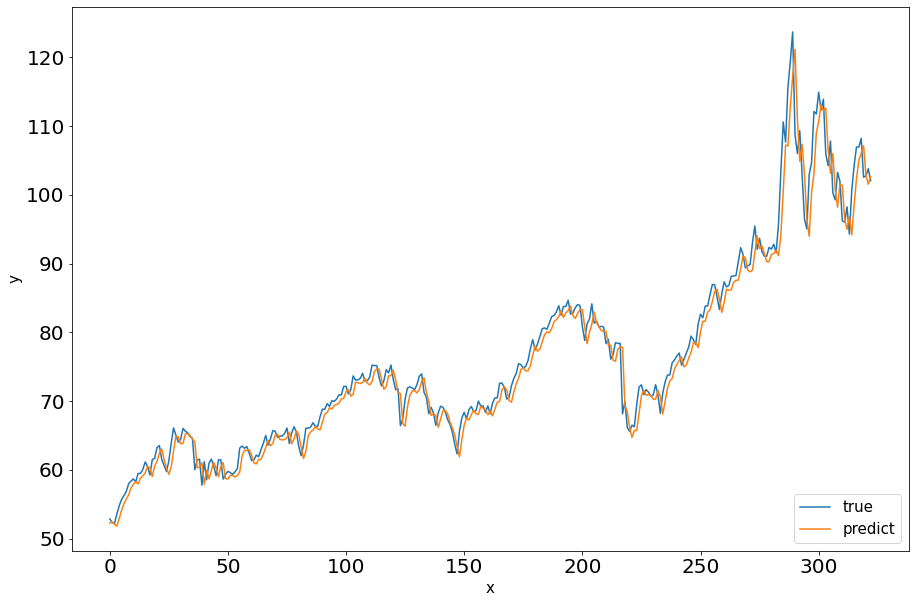

In [78]:
modelP_B1.genGraph()

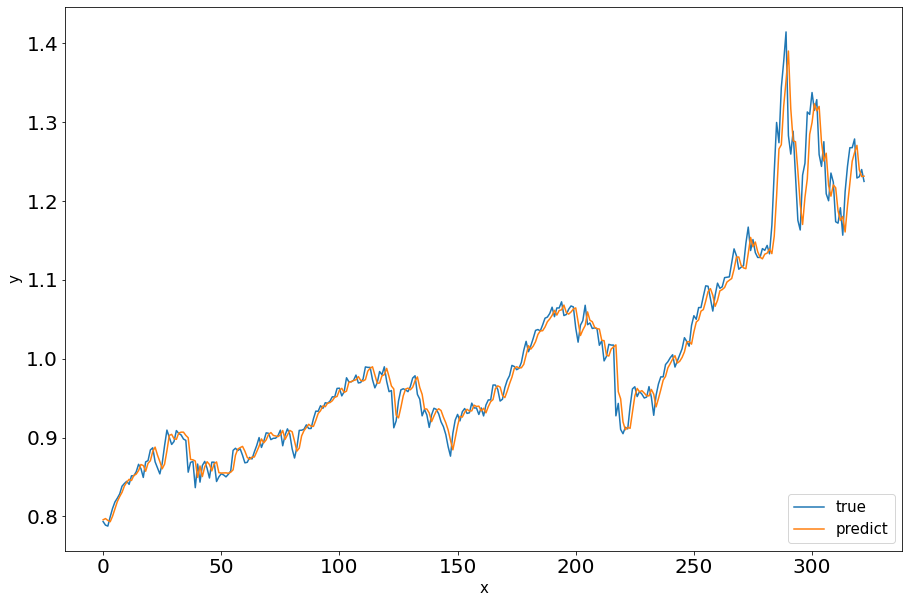

In [34]:
modelP.genGraph()

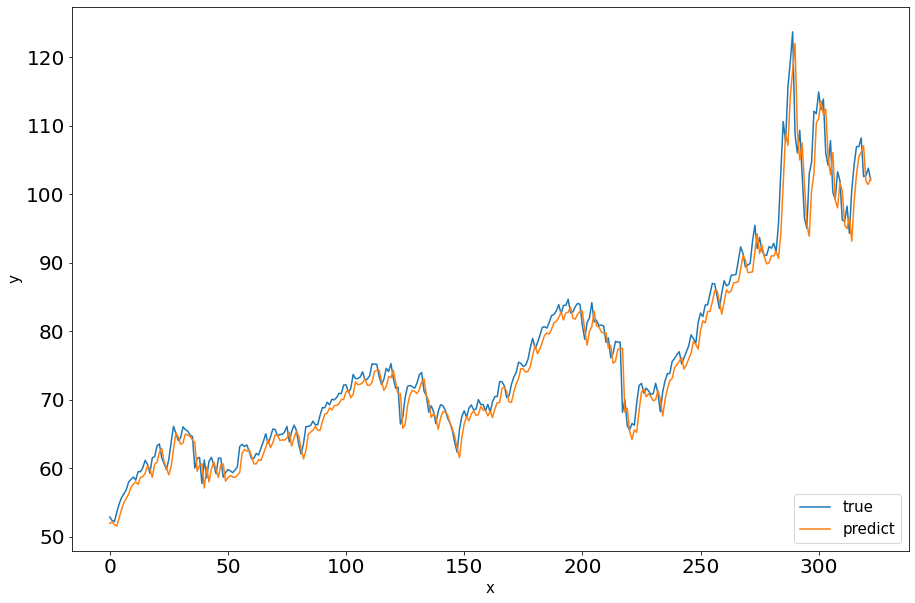

In [29]:
modelP.genGraph()

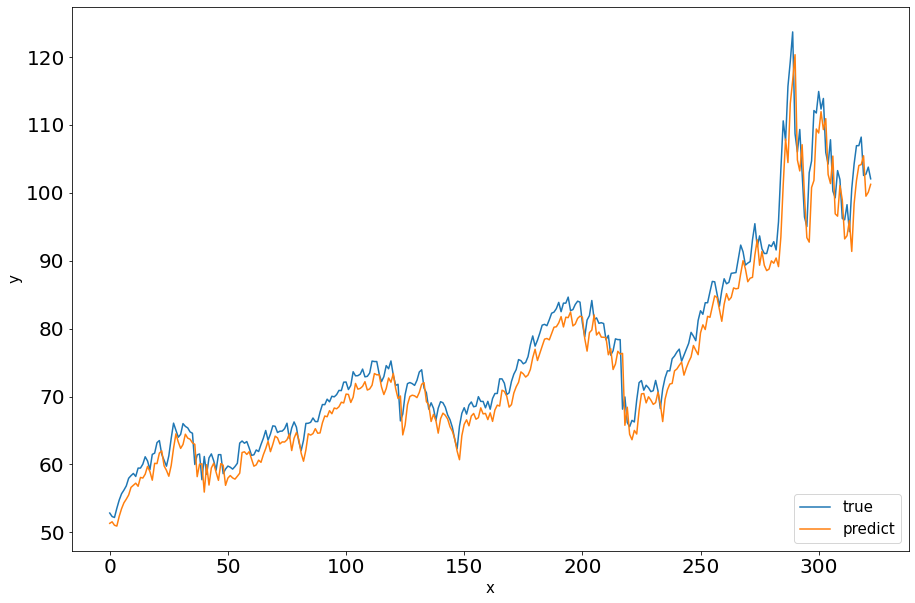

In [22]:
modelP.genGraph()

In [35]:
xTrain, yTrain, xTest, yTest = data.generate_train_test(5, factor=['USGG10YR', 'USGG2YR', 'DXY', 'OPECDALY', 'TIPX'])
modelPF = MLP(xTrain, yTrain, xTest, yTest)
modelPF.train()

Index(['CL1', 'USGG10YR', 'USGG2YR', 'DXY', 'OPECDALY', 'TIPX'], dtype='object')
Epoch 1/100
41/41 [==============================] - 0s 1ms/step - loss: 0.4098 - root_mean_squared_error: 0.6401
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 7.0068e-04 - root_mean_squared_error: 0.0265
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 6.0264e-04 - root_mean_squared_error: 0.0245
Epoch 5/100
41/41 [==============================] - 0s 955us/step - loss: 5.5307e-04 - root_mean_squared_error: 0.0235
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 5.4182e-04 - root_mean_squared_error: 0.0233
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 4.9194e-04 - root_mean_squared_error: 0.0222
Epoch 8/100
41/41 [==============================] - 0s 957us/step - loss: 5.5482e-04 - root_mean_s

41/41 [==============================] - 0s 968us/step - loss: 3.8608e-04 - root_mean_squared_error: 0.0196
Epoch 69/100
41/41 [==============================] - 0s 948us/step - loss: 3.8793e-04 - root_mean_squared_error: 0.0197
Epoch 70/100
41/41 [==============================] - 0s 913us/step - loss: 5.1404e-04 - root_mean_squared_error: 0.0227
Epoch 71/100
41/41 [==============================] - 0s 923us/step - loss: 4.7021e-04 - root_mean_squared_error: 0.0217
Epoch 72/100
41/41 [==============================] - 0s 934us/step - loss: 4.8236e-04 - root_mean_squared_error: 0.0220
Epoch 73/100
41/41 [==============================] - 0s 958us/step - loss: 4.8113e-04 - root_mean_squared_error: 0.0219
Epoch 74/100
41/41 [==============================] - 0s 917us/step - loss: 3.9204e-04 - root_mean_squared_error: 0.0198
Epoch 75/100
41/41 [==============================] - 0s 926us/step - loss: 4.7018e-04 - root_mean_squared_error: 0.0217
Epoch 76/100
41/41 [=========================

41/41 [==============================] - 0s 987us/step - loss: 5.4388e-04 - root_mean_squared_error: 0.0233
Epoch 36/100
41/41 [==============================] - 0s 980us/step - loss: 4.6633e-04 - root_mean_squared_error: 0.0216
Epoch 37/100
41/41 [==============================] - 0s 995us/step - loss: 6.2663e-04 - root_mean_squared_error: 0.0250
Epoch 38/100
41/41 [==============================] - 0s 929us/step - loss: 4.2699e-04 - root_mean_squared_error: 0.0207
Epoch 39/100
41/41 [==============================] - 0s 942us/step - loss: 4.9535e-04 - root_mean_squared_error: 0.0223
Epoch 40/100
41/41 [==============================] - 0s 1ms/step - loss: 5.5151e-04 - root_mean_squared_error: 0.0235
Epoch 41/100
41/41 [==============================] - 0s 966us/step - loss: 6.5569e-04 - root_mean_squared_error: 0.0256
Epoch 42/100
41/41 [==============================] - 0s 951us/step - loss: 4.6087e-04 - root_mean_squared_error: 0.0215
Epoch 43/100
41/41 [===========================

41/41 [==============================] - 0s 1ms/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 4/100
41/41 [==============================] - 0s 932us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 7/100
41/41 [==============================] - 0s 943us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 8/100
41/41 [==============================] - 0s 1ms/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 9/100
41/41 [==============================] - 0s 957us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 10/100
41/41 [==============================] - 0s 965us/step - loss: 0.6174 - root_mean

41/41 [==============================] - 0s 935us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 73/100
41/41 [==============================] - 0s 994us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 74/100
41/41 [==============================] - 0s 914us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 75/100
41/41 [==============================] - 0s 929us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 76/100
41/41 [==============================] - 0s 932us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 77/100
41/41 [==============================] - 0s 959us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 78/100
41/41 [==============================] - 0s 961us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 79/100
41/41 [==============================] - 0s 928us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 80/100
41/41 [==============================] - 0s 967us/step - loss: 0

41/41 [==============================] - 0s 915us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 42/100
41/41 [==============================] - 0s 961us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 43/100
41/41 [==============================] - 0s 911us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 44/100
41/41 [==============================] - 0s 935us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 45/100
41/41 [==============================] - 0s 934us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 46/100
41/41 [==============================] - 0s 941us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 47/100
41/41 [==============================] - 0s 944us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 48/100
41/41 [==============================] - 0s 927us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 49/100
41/41 [==============================] - 0s 957us/step - loss: 0

41/41 [==============================] - 0s 1ms/step - loss: 4.7647e-04 - root_mean_squared_error: 0.0218
Epoch 11/100
41/41 [==============================] - 0s 1ms/step - loss: 4.7185e-04 - root_mean_squared_error: 0.0217
Epoch 12/100
41/41 [==============================] - 0s 1ms/step - loss: 4.9424e-04 - root_mean_squared_error: 0.0222
Epoch 13/100
41/41 [==============================] - 0s 4ms/step - loss: 4.2379e-04 - root_mean_squared_error: 0.0206
Epoch 14/100
41/41 [==============================] - 0s 3ms/step - loss: 4.3422e-04 - root_mean_squared_error: 0.0208
Epoch 15/100
41/41 [==============================] - 0s 2ms/step - loss: 4.4193e-04 - root_mean_squared_error: 0.0210
Epoch 16/100
41/41 [==============================] - 0s 2ms/step - loss: 4.3618e-04 - root_mean_squared_error: 0.0209
Epoch 17/100
41/41 [==============================] - 0s 2ms/step - loss: 4.5869e-04 - root_mean_squared_error: 0.0214
Epoch 18/100
41/41 [==============================] - 0s 2ms/

41/41 [==============================] - 0s 1ms/step - loss: 5.0792e-04 - root_mean_squared_error: 0.0225
Epoch 79/100
41/41 [==============================] - 0s 933us/step - loss: 4.4771e-04 - root_mean_squared_error: 0.0212
Epoch 80/100
41/41 [==============================] - 0s 969us/step - loss: 4.7687e-04 - root_mean_squared_error: 0.0218
Epoch 81/100
41/41 [==============================] - 0s 936us/step - loss: 4.7881e-04 - root_mean_squared_error: 0.0219
Epoch 82/100
41/41 [==============================] - 0s 1ms/step - loss: 5.8168e-04 - root_mean_squared_error: 0.0241
Epoch 83/100
41/41 [==============================] - 0s 1ms/step - loss: 4.0159e-04 - root_mean_squared_error: 0.0200
Epoch 84/100
41/41 [==============================] - 0s 964us/step - loss: 5.7117e-04 - root_mean_squared_error: 0.0239
Epoch 85/100
41/41 [==============================] - 0s 958us/step - loss: 4.2735e-04 - root_mean_squared_error: 0.0207
Epoch 86/100
41/41 [==============================]

41/41 [==============================] - 0s 999us/step - loss: 4.5030e-04 - root_mean_squared_error: 0.0212
Epoch 46/100
41/41 [==============================] - 0s 976us/step - loss: 6.1118e-04 - root_mean_squared_error: 0.0247
Epoch 47/100
41/41 [==============================] - 0s 950us/step - loss: 4.4029e-04 - root_mean_squared_error: 0.0210
Epoch 48/100
41/41 [==============================] - 0s 969us/step - loss: 4.3579e-04 - root_mean_squared_error: 0.0209
Epoch 49/100
41/41 [==============================] - 0s 931us/step - loss: 7.1247e-04 - root_mean_squared_error: 0.0267
Epoch 50/100
41/41 [==============================] - 0s 951us/step - loss: 5.2823e-04 - root_mean_squared_error: 0.0230
Epoch 51/100
41/41 [==============================] - 0s 922us/step - loss: 6.1504e-04 - root_mean_squared_error: 0.0248
Epoch 52/100
41/41 [==============================] - 0s 1ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356
Epoch 53/100
41/41 [==============================]

41/41 [==============================] - 0s 999us/step - loss: 4.5203e-04 - root_mean_squared_error: 0.0213
Epoch 13/100
41/41 [==============================] - 0s 940us/step - loss: 4.3176e-04 - root_mean_squared_error: 0.0208
Epoch 14/100
41/41 [==============================] - 0s 969us/step - loss: 4.2974e-04 - root_mean_squared_error: 0.0207
Epoch 15/100
41/41 [==============================] - 0s 914us/step - loss: 4.4250e-04 - root_mean_squared_error: 0.0210
Epoch 16/100
41/41 [==============================] - 0s 940us/step - loss: 4.6665e-04 - root_mean_squared_error: 0.0216
Epoch 17/100
41/41 [==============================] - 0s 922us/step - loss: 4.4718e-04 - root_mean_squared_error: 0.0211
Epoch 18/100
41/41 [==============================] - 0s 955us/step - loss: 4.1462e-04 - root_mean_squared_error: 0.0204
Epoch 19/100
41/41 [==============================] - 0s 948us/step - loss: 4.0625e-04 - root_mean_squared_error: 0.0202
Epoch 20/100
41/41 [=========================

41/41 [==============================] - 0s 985us/step - loss: 4.5567e-04 - root_mean_squared_error: 0.0213
Epoch 80/100
41/41 [==============================] - 0s 999us/step - loss: 5.2209e-04 - root_mean_squared_error: 0.0228
Epoch 81/100
41/41 [==============================] - 0s 986us/step - loss: 5.2495e-04 - root_mean_squared_error: 0.0229
Epoch 82/100
41/41 [==============================] - 0s 921us/step - loss: 5.4444e-04 - root_mean_squared_error: 0.0233
Epoch 83/100
41/41 [==============================] - 0s 951us/step - loss: 4.0606e-04 - root_mean_squared_error: 0.0202
Epoch 84/100
41/41 [==============================] - 0s 942us/step - loss: 5.4600e-04 - root_mean_squared_error: 0.0234
Epoch 85/100
41/41 [==============================] - 0s 950us/step - loss: 4.4775e-04 - root_mean_squared_error: 0.0212
Epoch 86/100
41/41 [==============================] - 0s 945us/step - loss: 7.2112e-04 - root_mean_squared_error: 0.0269
Epoch 87/100
41/41 [=========================

41/41 [==============================] - 0s 969us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 48/100
41/41 [==============================] - 0s 948us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 49/100
41/41 [==============================] - 0s 981us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 50/100
41/41 [==============================] - 0s 912us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 51/100
41/41 [==============================] - 0s 969us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 52/100
41/41 [==============================] - 0s 911us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 53/100
41/41 [==============================] - 0s 959us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 54/100
41/41 [==============================] - 0s 954us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 55/100
41/41 [==============================] - 0s 962us/step - loss: 0

Epoch 16/100
41/41 [==============================] - 0s 962us/step - loss: 6.7525e-04 - root_mean_squared_error: 0.0260
Epoch 17/100
41/41 [==============================] - 0s 910us/step - loss: 6.1774e-04 - root_mean_squared_error: 0.0249
Epoch 18/100
41/41 [==============================] - 0s 944us/step - loss: 4.2315e-04 - root_mean_squared_error: 0.0206
Epoch 19/100
41/41 [==============================] - 0s 930us/step - loss: 4.5364e-04 - root_mean_squared_error: 0.0213
Epoch 20/100
41/41 [==============================] - 0s 934us/step - loss: 4.3894e-04 - root_mean_squared_error: 0.0210
Epoch 21/100
41/41 [==============================] - 0s 985us/step - loss: 0.0018 - root_mean_squared_error: 0.0427
Epoch 22/100
41/41 [==============================] - 0s 939us/step - loss: 9.6560e-04 - root_mean_squared_error: 0.0311
Epoch 23/100
41/41 [==============================] - 0s 982us/step - loss: 4.3931e-04 - root_mean_squared_error: 0.0210
Epoch 24/100
41/41 [================

41/41 [==============================] - 0s 1ms/step - loss: 4.7074e-04 - root_mean_squared_error: 0.0217
Epoch 84/100
41/41 [==============================] - 0s 1ms/step - loss: 4.7446e-04 - root_mean_squared_error: 0.0218
Epoch 85/100
41/41 [==============================] - 0s 1ms/step - loss: 4.8952e-04 - root_mean_squared_error: 0.0221
Epoch 86/100
41/41 [==============================] - 0s 1ms/step - loss: 4.1737e-04 - root_mean_squared_error: 0.0204
Epoch 87/100
41/41 [==============================] - 0s 1ms/step - loss: 4.0786e-04 - root_mean_squared_error: 0.0202
Epoch 88/100
41/41 [==============================] - 0s 1ms/step - loss: 4.2304e-04 - root_mean_squared_error: 0.0206
Epoch 89/100
41/41 [==============================] - 0s 1ms/step - loss: 3.6479e-04 - root_mean_squared_error: 0.0191
Epoch 90/100
41/41 [==============================] - 0s 981us/step - loss: 4.4165e-04 - root_mean_squared_error: 0.0210
Epoch 91/100
41/41 [==============================] - 0s 91

41/41 [==============================] - 0s 996us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 52/100
41/41 [==============================] - 0s 970us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 53/100
41/41 [==============================] - 0s 958us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 54/100
41/41 [==============================] - 0s 908us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 55/100
41/41 [==============================] - 0s 945us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 56/100
41/41 [==============================] - 0s 938us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 57/100
41/41 [==============================] - 0s 943us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 58/100
41/41 [==============================] - 0s 944us/step - loss: 0.6174 - root_mean_squared_error: 0.7857
Epoch 59/100
41/41 [==============================] - 0s 935us/step - loss: 0

41/41 [==============================] - 0s 1ms/step - loss: 5.3437e-04 - root_mean_squared_error: 0.0231
Epoch 21/100
41/41 [==============================] - 0s 1ms/step - loss: 9.5196e-04 - root_mean_squared_error: 0.0309
Epoch 22/100
41/41 [==============================] - 0s 1ms/step - loss: 4.9313e-04 - root_mean_squared_error: 0.0222
Epoch 23/100
41/41 [==============================] - 0s 1ms/step - loss: 6.1245e-04 - root_mean_squared_error: 0.0247
Epoch 24/100
41/41 [==============================] - 0s 1ms/step - loss: 8.2601e-04 - root_mean_squared_error: 0.0287
Epoch 25/100
41/41 [==============================] - 0s 1ms/step - loss: 5.6077e-04 - root_mean_squared_error: 0.0237
Epoch 26/100
41/41 [==============================] - 0s 1ms/step - loss: 6.8167e-04 - root_mean_squared_error: 0.0261
Epoch 27/100
41/41 [==============================] - 0s 1ms/step - loss: 5.2779e-04 - root_mean_squared_error: 0.0230
Epoch 28/100
41/41 [==============================] - 0s 1ms/

41/41 [==============================] - 0s 1ms/step - loss: 3.8658e-04 - root_mean_squared_error: 0.0197
Epoch 89/100
41/41 [==============================] - 0s 1ms/step - loss: 3.8973e-04 - root_mean_squared_error: 0.0197
Epoch 90/100
41/41 [==============================] - 0s 1ms/step - loss: 6.8973e-04 - root_mean_squared_error: 0.0263
Epoch 91/100
41/41 [==============================] - 0s 1ms/step - loss: 3.9381e-04 - root_mean_squared_error: 0.0198
Epoch 92/100
41/41 [==============================] - 0s 947us/step - loss: 3.9126e-04 - root_mean_squared_error: 0.0198
Epoch 93/100
41/41 [==============================] - 0s 1ms/step - loss: 4.2379e-04 - root_mean_squared_error: 0.0206
Epoch 94/100
41/41 [==============================] - 0s 966us/step - loss: 3.9415e-04 - root_mean_squared_error: 0.0199
Epoch 95/100
41/41 [==============================] - 0s 948us/step - loss: 5.8668e-04 - root_mean_squared_error: 0.0242
Epoch 96/100
41/41 [==============================] - 0

[0.00015730880841147155, 0.012542281299829483]

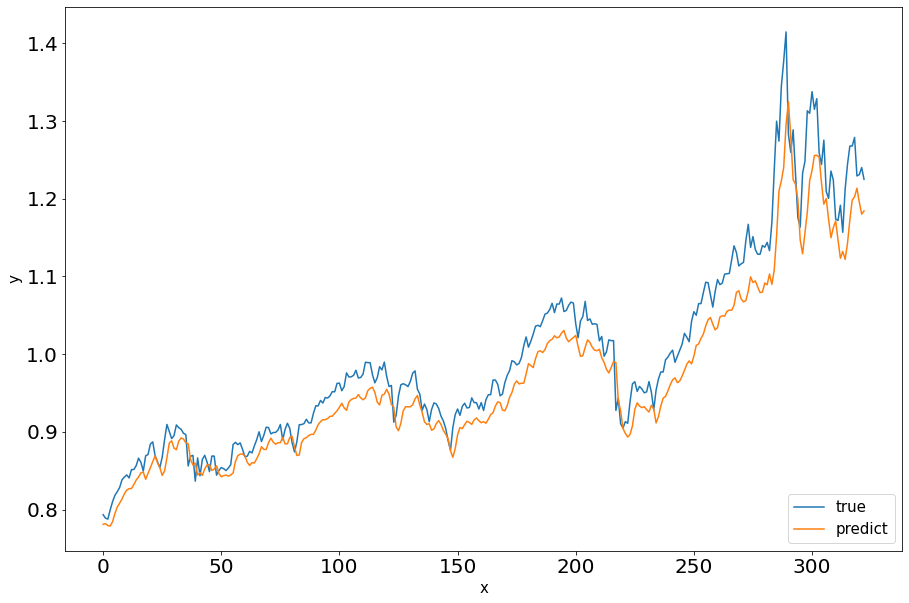

In [37]:
modelPF.genGraph()

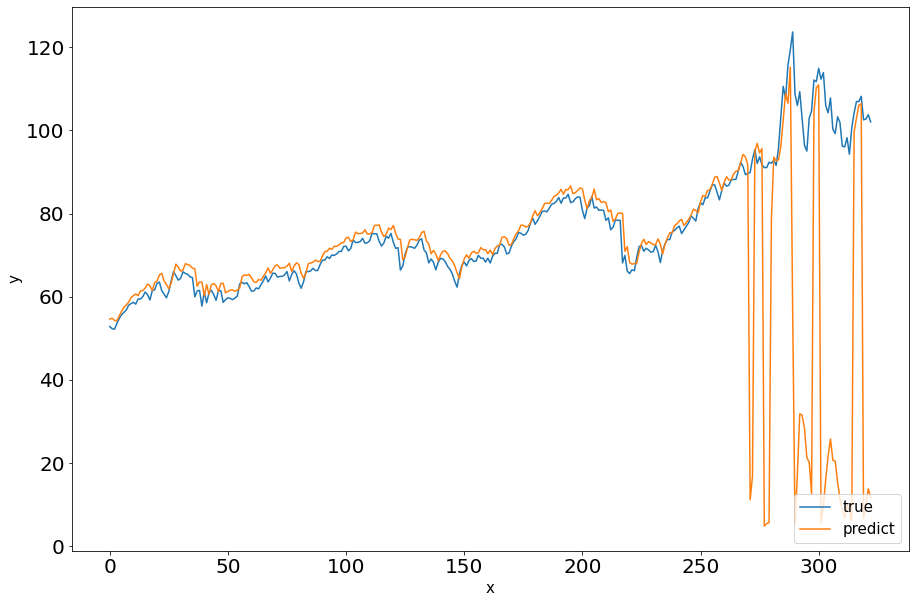

In [24]:
modelPF.genGraph()

In [ ]:
xTrain, yTrain, xTest, yTest = data.generate_train_test(5, factor=[])
model = MLP(xTrain, yTrain, xTest, yTest)
model.train()

In [ ]:
testLen = len(yTest)
modelP.predict()

plt.figure(figsize=(15, 10))
plt.rcParams["font.size"] = "20"
plt.plot(range(testLen), yTest, label="true")
plt.plot(range(testLen), modelP.yPred, label="predict")

plt.title(f"""CL1 prediction from {data.testStartDate.strftime("%Y-%m-%d")}""")
plt.ylabel("price", fontsize=15)
plt.xlabel("trading days", fontsize=15)
plt.legend(loc="lower right", fontsize=15)
# plt.savefig("Prediction of " + stock + ".png")
plt.show()

In [9]:
data.factors.columns

Index(['OXY', 'XOM', 'USGG10YR', 'USGG2YR', 'BSBYON', 'DXY', 'OPCRTOTL',
       'OPECDALY', 'EURUSD', 'MRO', 'TIPX', 'SPIP'],
      dtype='object')

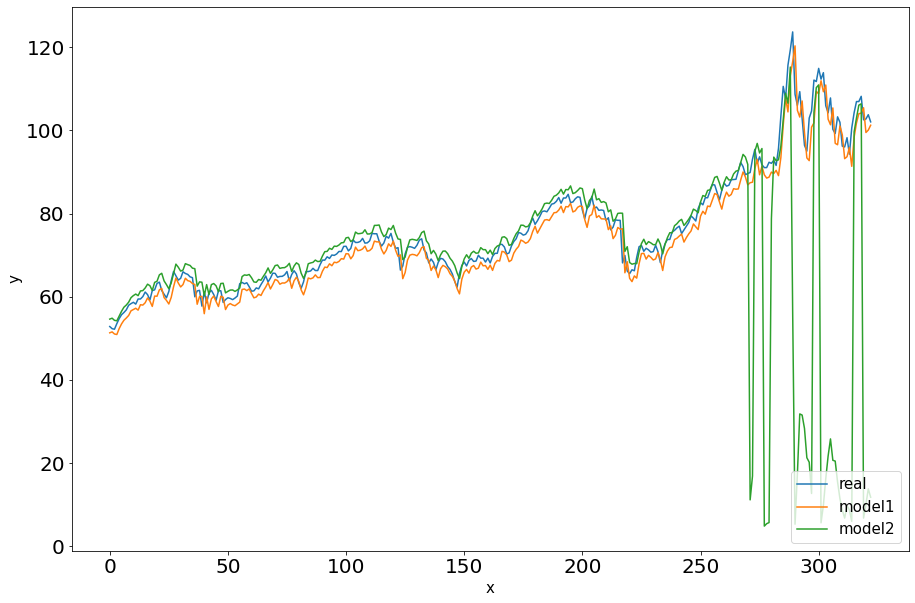

In [25]:
compareModelGraph(modelP, modelPF)

In [57]:
1 in None

TypeError: argument of type 'NoneType' is not iterable